# Advanced Tutorial: MCMC and Parameter Constraints

This tutorial covers advanced fitting techniques including Monte Carlo Markov Chain (MCMC) methods and parameter constraints. These are essential for:

- Quantifying parameter uncertainties
- Handling complex parameter relationships
- Understanding parameter correlations
- Dealing with non-Gaussian uncertainties

## Learning Objectives

By the end of this tutorial, you will:

- Understand when and why to use MCMC
- Know how to specify parameter constraints
- Interpret MCMC diagnostics
- Visualize posterior distributions
- Use constraints to enforce physical relationships


## 1. Setup


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ezfit.examples import rugged_noise

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 2. Why MCMC?

Traditional least-squares fitting assumes:

- Parameters have Gaussian uncertainties
- The covariance matrix fully describes uncertainties
- The best-fit is the "true" answer

MCMC provides:

- Full posterior distributions (not just means and covariances)
- Handles non-Gaussian uncertainties
- Shows parameter correlations
- Quantifies uncertainty in uncertainty estimates


## 3. Basic MCMC Fitting

Let's fit a complex model using MCMC:


,x,y,yerr
0,0.00000,-0.455903,1.227952
1,0.01001,-1.799031,1.899515
2,0.02002,0.482372,1.241186
3,0.03003,-1.118874,1.559437
4,0.04004,-1.018270,1.509135


/home/hduva/projects/ezfit/.venv/lib/python3.12/site-packages/ezfit/fit.py:232: UserWarning: Zero standard deviation found in covariance matrix diagonal,cannot compute correlation matrix.
  fit_result = _fit_curve_fit(


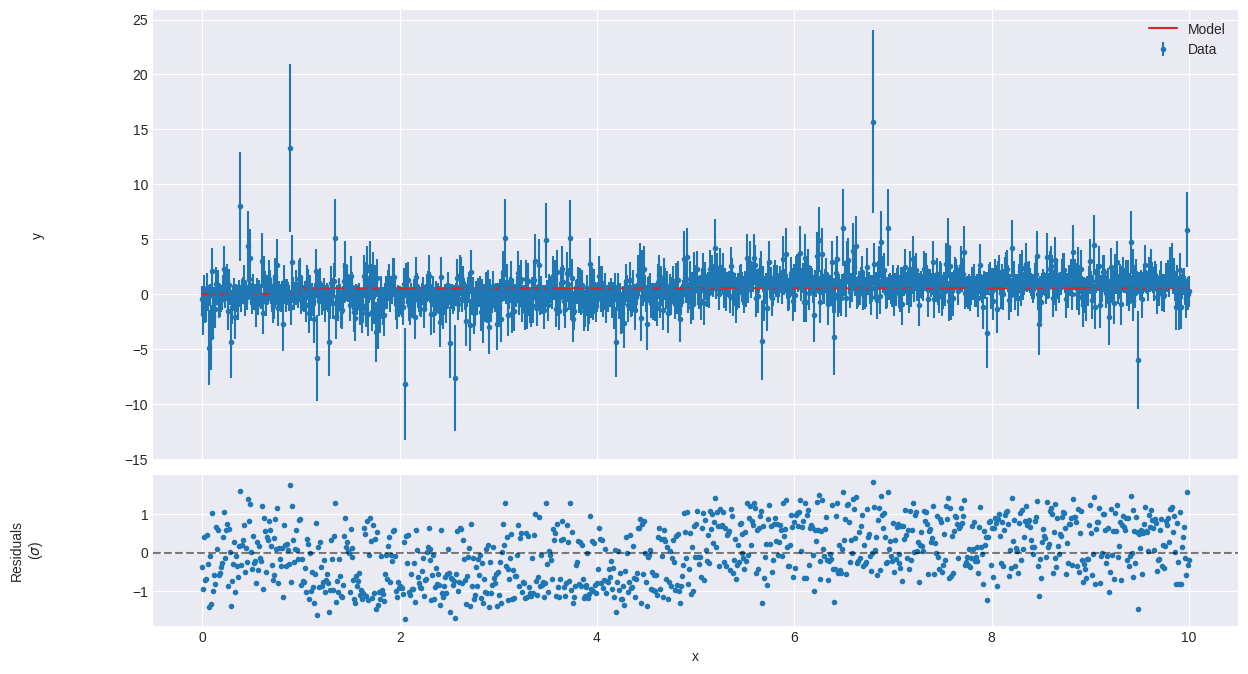

/home/hduva/projects/ezfit/.venv/lib/python3.12/site-packages/ezfit/fit.py:254: UserWarning: Could not invert Hessian to compute covariance matrix. Uncertainties not available.
  fit_result = _fit_differential_evolution(


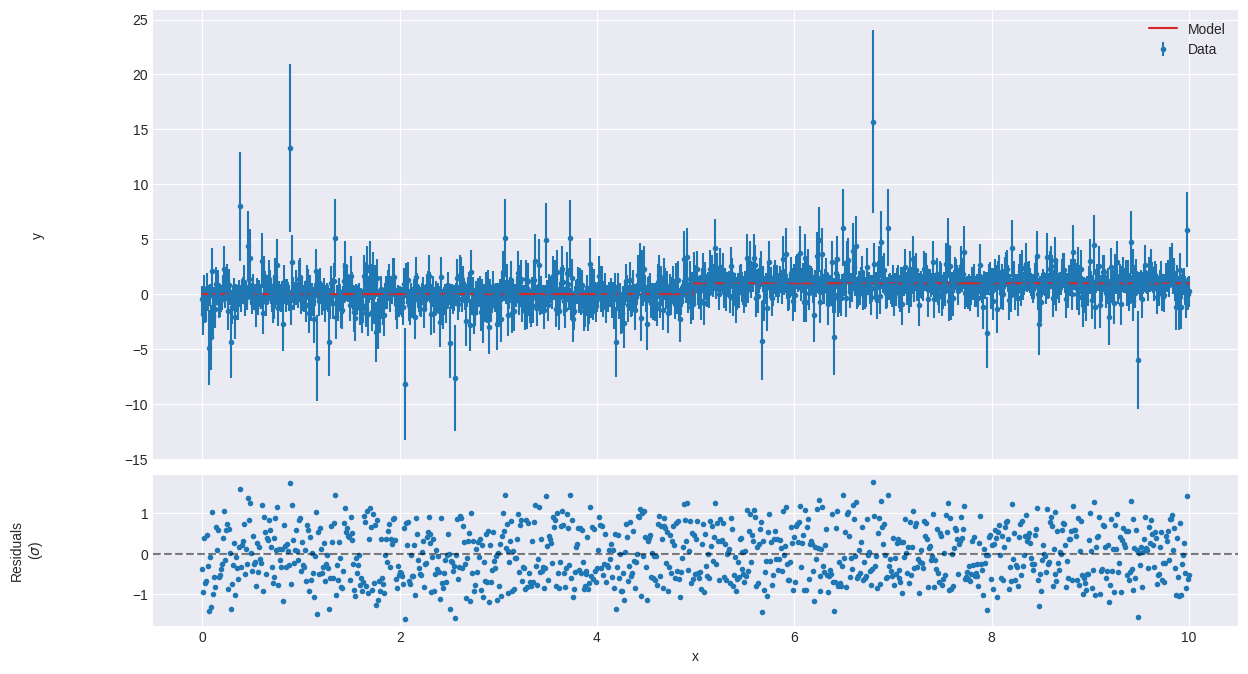

In [2]:
import pandas as pd
# Generate data using a step edge function with noise

def step_edge(x, c, H):
    return H * (x > c)

def generate_step_edge_data(c, H, x_range, n_points, noise_level):
    x = np.linspace(x_range[0], x_range[1], n_points)
    y = step_edge(x, c, H)
    y, y_truth, noise = rugged_noise(y, noise_level)
    y_err = noise_level * (1.0 + 0.5 * np.abs(noise) / noise_level)
    return pd.DataFrame({'x': x, 'y': y, 'yerr': y_err})

df = generate_step_edge_data(c=5, H=1, x_range=(0, 10), n_points=1000, noise_level=1)
display(df.head())

# Fit the data
domain = {
    "c": {"value": 1, "min": 0, "max": 10},
    "H": {"value": 1, "min": 0, "max": 10}
}

model_fit, ax_fit, _ = df.fit(
    step_edge, "x", "y", "yerr",
    **domain
)

plt.show()

model_fit, ax_fit, _ = df.fit(
    step_edge, "x", "y", "yerr",
    method="differential_evolution",
    **domain
)

plt.show()



Step 2: Run MCMC for full uncertainty analysis


100%|██████████| 2000/2000 [00:02<00:00, 906.37it/s]
/home/hduva/projects/ezfit/.venv/lib/python3.12/site-packages/ezfit/fit.py:286: UserWarning: MCMC chain may not have converged. R-hat: 3.055761540271962, ESS: 215.71689411015436
  fit_result = _fit_emcee(


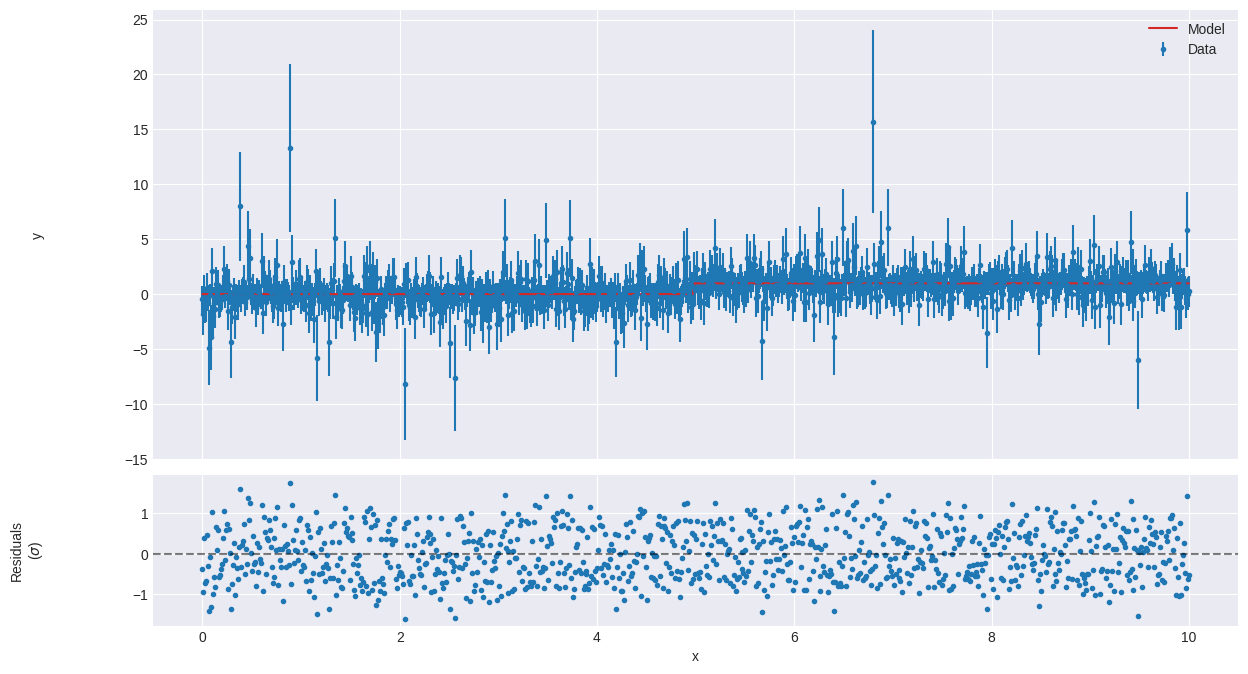


MCMC Fit Results:
step_edge
c : (value = 4.98 ± 0.074, bounds = (0, 10))
H : (value = 0.98 ± 0.053, bounds = (0, 10))
𝜒2: 426.16686931634837
reduced 𝜒2: 0.4270209111386256
covariance:
[[0.0051 0.0003]
 [0.0003 0.0032]]
correlation:
[[1.     0.0683]
 [0.0683 1.    ]]


In [3]:
# Now run MCMC starting from the best-fit values
print("\nStep 2: Run MCMC for full uncertainty analysis")
model_mcmc, ax_mcmc, _ = df.fit(
    step_edge, "x", "y", "yerr",
    method="emcee",
    fit_kwargs={
        "nwalkers": 50,
        "nsteps": 2000,
        "progress": True
    },
    **domain
)

plt.show()
print("\nMCMC Fit Results:")
print(model_mcmc)

## 4. MCMC Diagnostics

It's crucial to check that your MCMC chain has converged. ezfit provides built-in diagnostics:


In [4]:
# Print summary with diagnostics
print(model_mcmc.summary())

Model: step_edge
Function Signature: (x, c, H)
Parameters:
  [0] c: (value = 4.98 ± 0.074, bounds = (0, 10))
  [1] H: (value = 0.98 ± 0.053, bounds = (0, 10))

Chi-squared (𝜒2): 426.2
Reduced Chi-squared (r𝜒2): 0.427


MCMC Diagnostics:
  R-hat: 3.0558
  ESS: 215.72
  Burn-in: 40
  Effective samples: 431433
  Converged: False


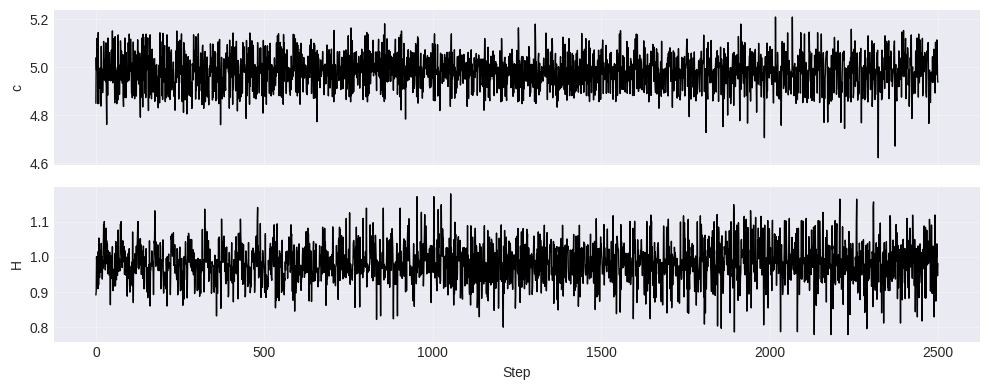


Trace plots show:
- Each walker's path through parameter space
- Whether chains have converged (should look like 'hairy caterpillars')
- Whether burn-in period is sufficient


In [5]:
# Visualize the chain convergence with trace plots
fig, axes = model_mcmc.plot_trace()
plt.show()

print("\nTrace plots show:")
print("- Each walker's path through parameter space")
print("- Whether chains have converged (should look like 'hairy caterpillars')")
print("- Whether burn-in period is sufficient")

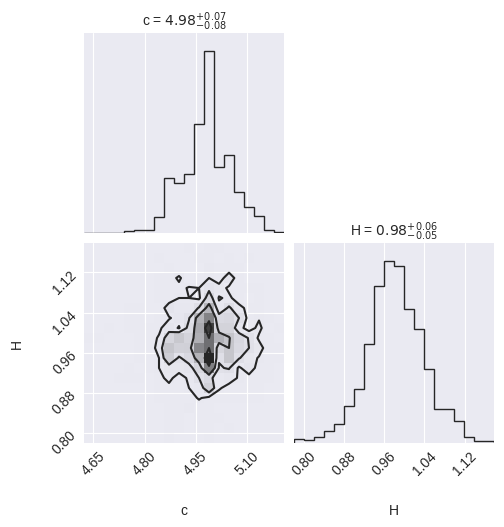


Corner plot shows:
- Marginal posterior distributions for each parameter
- Parameter correlations (off-diagonal panels)
- 16th, 50th (median), and 84th percentiles


In [6]:
# Corner plot shows parameter distributions and correlations
fig, axes = model_mcmc.plot_corner()
plt.show()

print("\nCorner plot shows:")
print("- Marginal posterior distributions for each parameter")
print("- Parameter correlations (off-diagonal panels)")
print("- 16th, 50th (median), and 84th percentiles")

## 5. Accessing Posterior Samples

You can extract posterior samples for custom analysis:


In [7]:
# Get posterior samples
samples = model_mcmc.get_posterior_samples()
print(f"Shape of posterior samples: {samples.shape}")
print(f"Number of samples: {samples.shape[0]}")
print(f"Number of parameters: {samples.shape[1]}")

# Compute custom statistics
param_names = list(model_mcmc.params.keys())
for i, name in enumerate(param_names):
    param_samples = samples[:, i]
    print(f"\n{name}:")
    print(f"  Mean: {np.mean(param_samples):.4f}")
    print(f"  Median: {np.median(param_samples):.4f}")
    print(f"  Std: {np.std(param_samples):.4f}")
    print(f"  95% CI: [{np.percentile(param_samples, 2.5):.4f}, {np.percentile(param_samples, 97.5):.4f}]")

Shape of posterior samples: (2500, 2)
Number of samples: 2500
Number of parameters: 2

c:
  Mean: 4.9813
  Median: 4.9825
  Std: 0.0714
  95% CI: [4.8489, 5.1255]

H:
  Mean: 0.9822
  Median: 0.9799
  Std: 0.0570
  95% CI: [0.8636, 1.1004]


## 6. Parameter Constraints

Sometimes you need to enforce relationships between parameters. For example:

- Peak 1 must be narrower than Peak 2
- Amplitudes must sum to less than a certain value
- One parameter must be greater than another


Fitting with constraint: w1 < w2


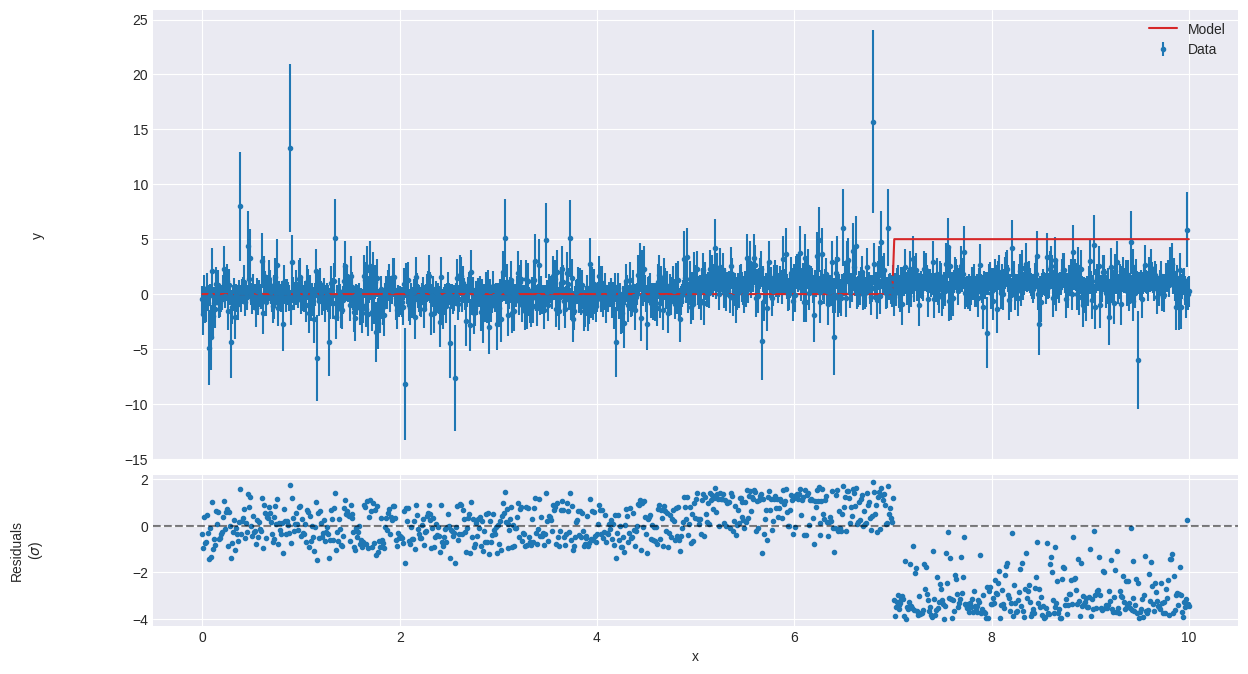


Constrained fit:
  c = 7.0000 ± nan
  H = 5.0000 ± nan


In [12]:
# Example: Constrain that peak 1 is narrower than peak 2
# w1 < w2

print("Fitting with constraint: w1 < w2")
model_constrained, ax_const, _ = df.fit(
    step_edge, "x", "y", "yerr",
    method="minimize",  # Constraints work with minimize, differential_evolution, and MCMC
    fit_kwargs={"method": "SLSQP"},  # SLSQP supports constraints
    c={"value": 7.0, "min": 0, "max": 15},
    H={"value": 7.0, "min": 5, "max": 9},
)

plt.show()
print("\nConstrained fit:")
print(f"  c = {model_constrained['c'].value:.4f} ± {model_constrained['c'].err:.4f}")
print(f"  H = {model_constrained['H'].value:.4f} ± {model_constrained['H'].err:.4f}")


Fitting with constraint: A1 + A2 < 15


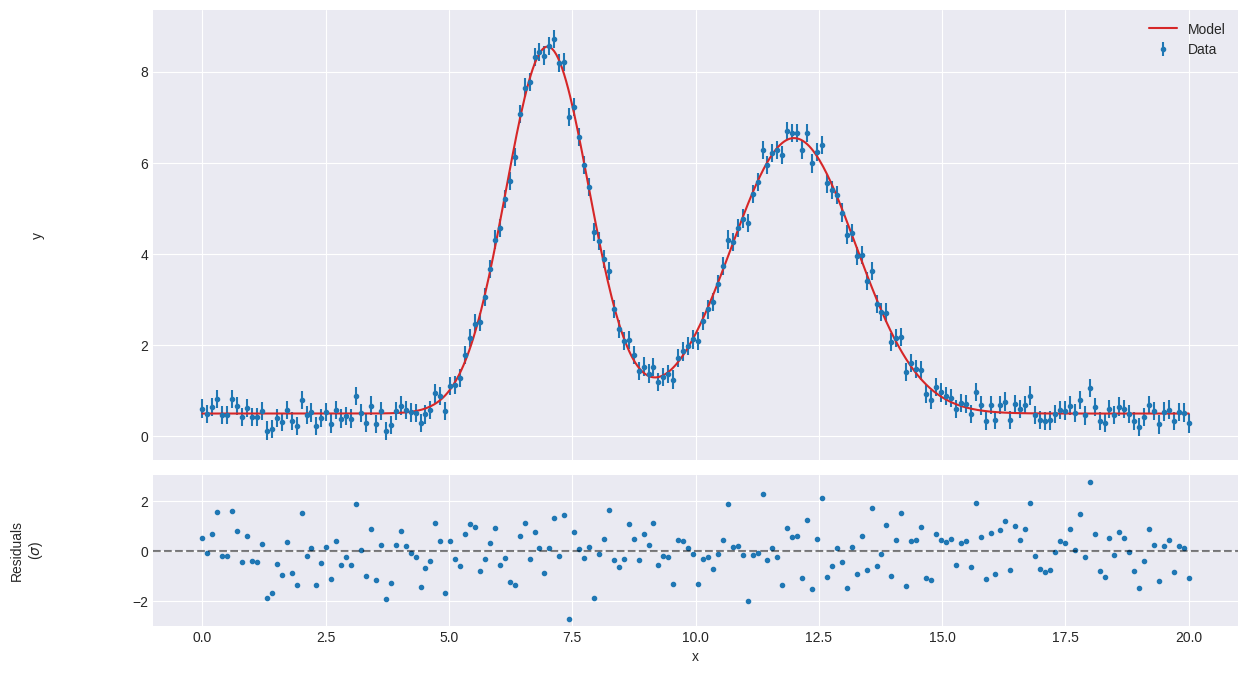


Sum constraint fit:
  A1 = 8.0552
  A2 = 6.0485
  A1 + A2 = 14.1037 < 15


In [9]:
# More complex constraint: Sum of amplitudes < 15
from ezfit import sum_less_than

print("\nFitting with constraint: A1 + A2 < 15")
model_sum_constraint, ax_sum, _ = df.fit(
    two_gaussians, "x", "y", "yerr",
    method="minimize",
    fit_kwargs={"method": "SLSQP"},
    A1={
        "value": 7.0,
        "min": 0,
        "max": 15,
        "constraint": sum_less_than(["A1", "A2"], 15.0)  # Function constraint
    },
    c1={"value": 7.0, "min": 5, "max": 9},
    w1={"value": 2.0, "min": 0.5, "max": 5},
    A2={"value": 5.0, "min": 0, "max": 15},
    c2={"value": 12.0, "min": 10, "max": 14},
    w2={"value": 3.0, "min": 0.5, "max": 5},
    B={"value": 0.5, "min": 0, "max": 2}
)

plt.show()
print("\nSum constraint fit:")
print(f"  A1 = {model_sum_constraint['A1'].value:.4f}")
print(f"  A2 = {model_sum_constraint['A2'].value:.4f}")
print(f"  A1 + A2 = {model_sum_constraint['A1'].value + model_sum_constraint['A2'].value:.4f} < 15")

## 7. MCMC with Constraints

Constraints also work with MCMC! The sampler will automatically reject proposals that violate constraints:


Running MCMC with constraint: w1 < w2


100%|██████████| 1500/1500 [00:03<00:00, 472.96it/s]


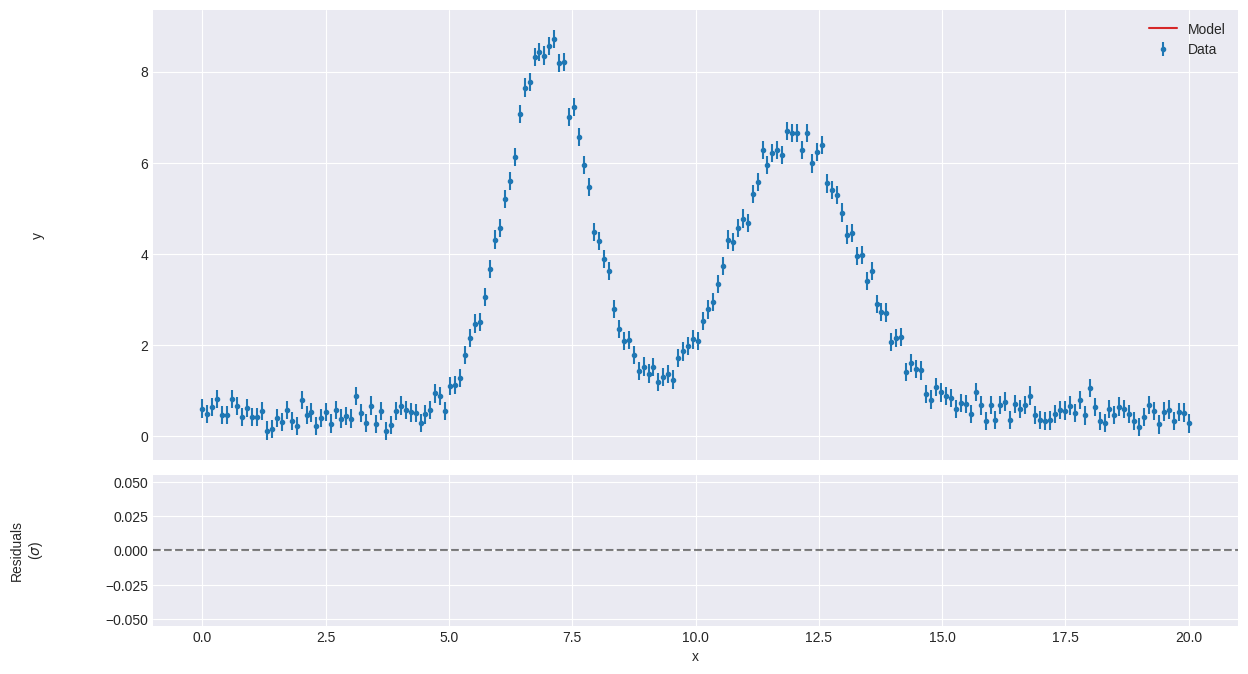


MCMC with constraint:
Model: two_gaussians
Function Signature: (x, A1, c1, w1, A2, c2, w2, B)
Parameters:
  [0] A1: (value = nan ± N/A, bounds = (0, 15))
  [1] c1: (value = nan ± N/A, bounds = (5, 9))
  [2] w1: (value = nan ± N/A, bounds = (0.5, 5))
  [3] A2: (value = nan ± N/A, bounds = (0, 15))
  [4] c2: (value = nan ± N/A, bounds = (10, 14))
  [5] w2: (value = nan ± N/A, bounds = (0.5, 5))
  [6] B: (value = nan ± N/A, bounds = (0, 2))

Chi-squared (𝜒2): nan
Reduced Chi-squared (r𝜒2): nan


Constraint satisfied in all samples: True


In [11]:
print("Running MCMC with constraint: w1 < w2")
model_mcmc_constrained, ax_mcmc_const, _ = df.fit(
    two_gaussians, "x", "y", "yerr",
    method="emcee",
    fit_kwargs={
        "nwalkers": 50,
        "nsteps": 1500,
        "progress": True
    },
    A1={"value": 7.0, "min": 0, "max": 15},
    c1={"value": 7.0, "min": 5, "max": 9},
    w1={"value": 2.0, "min": 0.5, "max": 5, "constraint": "w1 < w2"},
    A2={"value": 5.0, "min": 0, "max": 15},
    c2={"value": 12.0, "min": 10, "max": 14},
    w2={"value": 3.0, "min": 0.5, "max": 5},
    B={"value": 0.5, "min": 0, "max": 2}
)

plt.show()
print("\nMCMC with constraint:")
print(model_mcmc_constrained.summary())

# Verify constraint in posterior
samples_const = model_mcmc_constrained.get_posterior_samples()
w1_samples = samples_const[:, 2]  # w1 is 3rd parameter (index 2)
w2_samples = samples_const[:, 5]  # w2 is 6th parameter (index 5)
constraint_satisfied = np.all(w1_samples < w2_samples)
print(f"\nConstraint satisfied in all samples: {constraint_satisfied}")

## 8. Comparing Traditional vs MCMC Uncertainties

Let's compare the uncertainty estimates:


In [12]:
print("Comparison of Uncertainty Estimates:")
print("="*60)
print(f"{'Parameter':<10} {'curve_fit':<20} {'MCMC':<20}")
print("-"*60)

for name in param_names:
    curve_fit_val = model_init[name].value
    curve_fit_err = model_init[name].err

    mcmc_samples = samples[:, param_names.index(name)]
    mcmc_median = np.median(mcmc_samples)
    mcmc_err = (np.percentile(mcmc_samples, 84) - np.percentile(mcmc_samples, 16)) / 2

    print(f"{name:<10} {curve_fit_val:7.4f} ± {curve_fit_err:6.4f}    {mcmc_median:7.4f} ± {mcmc_err:6.4f}")

print("\nNote: MCMC provides percentiles (16th-84th) which may differ from")
print("Gaussian uncertainties, especially for non-Gaussian posteriors.")

Comparison of Uncertainty Estimates:
Parameter  curve_fit            MCMC                
------------------------------------------------------------
A1          8.0553 ± 0.0655     8.0556 ± 0.0647
c1          6.9973 ± 0.0077     6.9973 ± 0.0077
w1          1.9922 ± 0.0193     1.9927 ± 0.0186
A2          6.0485 ± 0.0545     6.0476 ± 0.0541
c2         11.9951 ± 0.0126    11.9953 ± 0.0127
w2          2.9739 ± 0.0324     2.9741 ± 0.0335
B           0.4900 ± 0.0204     0.4897 ± 0.0202

Note: MCMC provides percentiles (16th-84th) which may differ from
Gaussian uncertainties, especially for non-Gaussian posteriors.


## Summary

In this advanced tutorial, you learned:

1. ✅ When and why to use MCMC for fitting
2. ✅ How to run MCMC fits with ezfit
3. ✅ How to check convergence with diagnostics
4. ✅ How to visualize posterior distributions
5. ✅ How to specify parameter constraints (string and function-based)
6. ✅ How constraints work with both traditional and MCMC methods

**Key Takeaways:**

- **MCMC** is essential when you need:

  - Full posterior distributions (not just means/covariances)
  - To handle non-Gaussian uncertainties
  - To understand parameter correlations
  - Robust uncertainty quantification

- **Constraints** are useful for:
  - Enforcing physical relationships
  - Ensuring parameter ordering
  - Limiting parameter combinations
  - Incorporating prior knowledge

**Next Steps:**

- Read the full API documentation
- Experiment with your own models and constraints
- Explore the visualization tools in `ezfit.visualization`
